In [8]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from multiprocessing import get_context
from typing import Optional, Tuple, List
from path_helpers import process_edge
from ortools.linear_solver import pywraplp
from IPython.display import Image, display

def create_animation(steps: List[List[int]], points: np.ndarray, filename: str = 'path_building_parallel.gif'):
    """Create animation of path building process."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("Building the Best Hamiltonian Path Step-by-Step")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.grid(True)
    ax.set_aspect('equal')

    ax.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)
    for idx, (x, y) in enumerate(points):
        ax.text(x + 0.01, y + 0.01, str(idx), fontsize=12)

    line, = ax.plot([], [], 'o-', color='red', markersize=8, zorder=1)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        current_path = steps[i]
        path_points = points[list(current_path)]
        line.set_data(path_points[:, 0], path_points[:, 1])
        ax.set_title(f"Step {i}: Building the Path")
        return line,

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=len(steps), interval=1000, blit=True)
    ani.save(filename, writer='pillow')
    plt.close()
    print(f"Animation saved as {filename}")

def solve_hamiltonian_path_with_distances(distance_matrix):
    """Solve for optimal Hamiltonian path using OR-Tools."""
    n = len(distance_matrix)
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    if not solver:
        raise Exception("SCIP solver is not available.")

    # Create variables for edges
    edges = {}
    for i in range(n):
        for j in range(n):
            if i != j:
                edges[i, j] = solver.BoolVar(f'edge_{i}_{j}')

    # Create position variables for MTZ subtour elimination
    positions = {}
    for i in range(1, n):
        positions[i] = solver.IntVar(1, n - 1, f'position_{i}')

    # Constraint: Each node has exactly one outgoing edge
    for i in range(n):
        solver.Add(sum(edges[i, j] for j in range(n) if j != i) == 1)

    # Constraint: Each node has exactly one incoming edge
    for j in range(n):
        solver.Add(sum(edges[i, j] for i in range(n) if i != j) == 1)

    # Subtour elimination using MTZ constraints
    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                solver.Add(positions[i] - positions[j] + n * edges[i, j] <= n - 1)

    # Objective: Minimize total distance
    objective = solver.Objective()
    for i in range(n):
        for j in range(n):
            if i != j:
                objective.SetCoefficient(edges[i, j], distance_matrix[i][j])
    objective.SetMinimization()

    # Solve
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        # Extract the path
        path = []
        current_node = 0  # Start from node 0
        while len(path) < n:
            path.append(current_node)
            for j in range(n):
                if j != current_node and edges[current_node, j].solution_value() > 0.5:
                    current_node = j
                    break

        # Compute total distance
        total_distance = sum(
            distance_matrix[path[i]][path[i + 1]]
            for i in range(len(path) - 1)
        )
        
        return path, total_distance

    return None, None

def plot_comparison(custom_path, ortools_path, points, custom_distance, ortools_distance):
    """Plot comparison between custom algorithm and OR-Tools solution."""
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Comparison of Custom Algorithm and OR-Tools Hamiltonian Path Solution")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.grid(True)
    ax.set_aspect('equal')

    # Determine plot limits with margin
    margin = 0.05
    x_min, x_max = points[:, 0].min() - margin, points[:, 0].max() + margin
    y_min, y_max = points[:, 1].min() - margin, points[:, 1].max() + margin
    overall_min = min(x_min, y_min)
    overall_max = max(x_max, y_max)
    ax.set_xlim(overall_min, overall_max)
    ax.set_ylim(overall_min, overall_max)

    # Scatter plot of all points
    ax.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)

    # Annotate points
    for idx, (x, y) in enumerate(points):
        ax.text(x + 0.01, y + 0.01, str(idx), fontsize=12)

    # Plot Custom Path
    custom_path_points = points[list(custom_path)]
    ax.plot(custom_path_points[:, 0], custom_path_points[:, 1], 'o-', color='red',
            label=f'Custom Path ({custom_distance:.4f})', markersize=8)

    # Plot OR-Tools Path
    ortools_path_points = points[list(ortools_path)]
    ax.plot(ortools_path_points[:, 0], ortools_path_points[:, 1], 'o--', color='green',
            label=f'OR-Tools Path ({ortools_distance:.4f})', markersize=8)

    ax.legend()
    plt.show()

def main_parallel_hamiltonian_path(n: int = 16, seed: int = 42) -> Tuple[Optional[List[int]], Optional[float], np.ndarray]:
    """Main function to execute the parallel Hamiltonian Path algorithm."""
    print(f"Running Parallel Hamiltonian Path Algorithm with n={n} and seed={seed}...")
    
    np.random.seed(seed)
    points = np.random.rand(n, 2)
    
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = np.linalg.norm(points[i] - points[j])
    
    edges = list(itertools.combinations(range(n), 2))
    print(f"Total number of starting edges to process: {len(edges)}")
    
    start_time = time.time()

    # Prepare arguments for multiprocessing
    args_list = [(edge, n, distance_matrix) for edge in edges]

    # Use multiprocessing with 'spawn' start method
    ctx = get_context('spawn')
    with ctx.Pool() as pool:
        results = pool.map(process_edge, args_list)

    # Filter out None results and find the best path
    complete_paths = [result for result in results if result is not None]
    
    end_time = time.time()
    print(f"\nTotal computation time: {end_time - start_time:.2f} seconds")

    if complete_paths:
        best_result = min(complete_paths, key=lambda x: x[0])
        best_distance, best_path, best_steps = best_result
        
        print("\nBest Hamiltonian Path (Parallel Algorithm with Lookahead):")
        print(best_path)
        print(f"Total Distance: {best_distance:.4f}")
        
        # Create animation for the best path
        create_animation(best_steps, points)

        # Solve using OR-Tools and compare
        ortools_path, ortools_distance = solve_hamiltonian_path_with_distances(distance_matrix)
        
        if ortools_path is not None:
            print("\nComparison with OR-Tools:")
            print(f"Custom Algorithm Distance: {best_distance:.4f}")
            print(f"OR-Tools Distance: {ortools_distance:.4f}")
            improvement = ((best_distance - ortools_distance) / ortools_distance) * 100
            print(f"Improvement by OR-Tools: {improvement:.2f}%")
            
            # Plot comparison
            plot_comparison(best_path, ortools_path, points, best_distance, ortools_distance)
            
        display(Image(filename='path_building_parallel.gif'))
        
        return best_path, best_distance
    else:
        print("\nNo complete path was found.")
        return None, None

Running Parallel Hamiltonian Path Algorithm with n=16 and seed=567...
Total number of starting edges to process: 120

Total computation time: 2.92 seconds

Best Hamiltonian Path (Parallel Algorithm with Lookahead):
[11, 13, 9, 14, 7, 2, 1, 10, 6, 4, 3, 15, 5, 0, 8, 12]
Total Distance: 3.1181
Animation saved as path_building_parallel.gif

Comparison with OR-Tools:
Custom Algorithm Distance: 3.1181
OR-Tools Distance: 3.5648
Improvement by OR-Tools: -12.53%


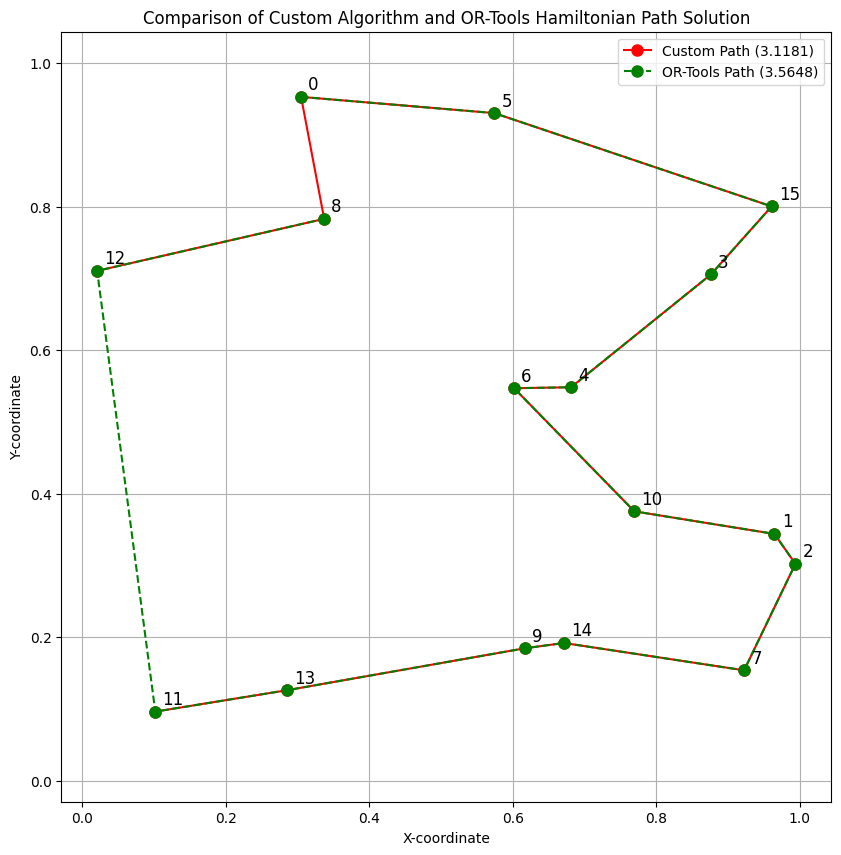

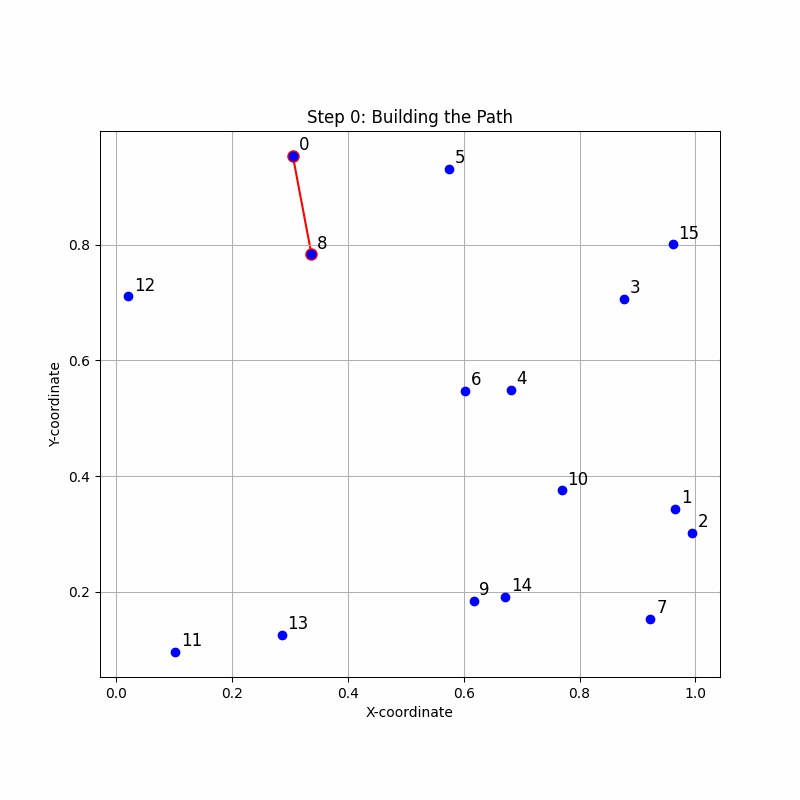

([11, 13, 9, 14, 7, 2, 1, 10, 6, 4, 3, 15, 5, 0, 8, 12],
 np.float64(3.1180613178802075))

In [9]:
main_parallel_hamiltonian_path(n=16, seed=567)